# Test Code for Prob & Stats Final Project

In [1]:
from typing import Union, List, Iterable, Tuple
import datetime
import numpy as np
import pandas as pd
%matplotlib inline
import pandas_datareader.data as web
from pandas_datareader import data as web
import yfinance as yf
from scipy import stats
import scipy
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm

### Define all functions

In [40]:
def plot_hist(df: pd.DataFrame, symbol: Union[str, List[str]] = None):
    """
    Plot histogram(s) of log-return(s) of given symbol (or set of symbols).
    
    Args:
        df: Dataframe of log-returns.
        symbol: Symbol(s) of the stock(s).
    """
    
    if not symbol:
        symbol = list(df.columns)
    
    if isinstance(symbol, str):
        symbol = [symbol]
    
    ncols = min(3, len(symbol))
    nrows = math.ceil(len(symbol) / 3)
    figsize = (5 * ncols, 4 * nrows)
    
    df[symbol].hist(bins = 50, figsize = figsize, layout = (nrows, ncols))
    plt.show()
    

def probplot(df, symbol: Union[str, List[str]] = None):
    """
    Plot normal probability plot(s) of log-return(s) 
    of given symbol (or set of symbols).
    
    Args:
        df: Dataframe of log-returns.
        symbol: Symbol(s) of the stock(s).
    """
    
    if not symbol:
        symbol = list(df.columns)
    
    if isinstance(symbol, str):
        symbol = [symbol]
        
    ncols = min(3, len(symbol))
    nrows = math.ceil(len(symbol) / 3)
    figsize = (5 * ncols, 4 * nrows)

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
    
    if not isinstance(axs, Iterable):
        axs = np.array([[axs]])
    
    if len(axs.shape) == 1:
        axs = axs[None, :]

    for i, sym in enumerate(symbol):
        r = i//ncols
        c = i%ncols
        res = stats.probplot(log_return[sym], plot=axs[r][c])
        axs[r][c].set_title(sym)
        

def confidence_interval(df: pd.DataFrame, 
                        symbol: Union[str, List[str]] = None, 
                        conf_level: float = 0.95
                       ) -> pd.DataFrame:
    """
    Computes confidence intervals of given symbol (or set of symbols).
    
    Args:
        df: Dataframe of log-returns.
        symbol: Symbol(s) of the stock(s).
        conf_level: confidence level. Default is 0.95.
        
    Returns:
        Dataframe with 2 columns ['lower_bound', 'uppe_bound'],
            each row corresponds to each symbol.
    """
    
    alpha = (1 - conf_level)
    
    if not symbol:
        symbol = list(df.columns)
    
    if isinstance(symbol, str):
        symbol = [symbol]
    
    sample_mean = df[symbol].mean()
    sample_variance = df[symbol].var()
    
    t_value = scipy.stats.t.ppf(1 - (alpha / 2), len(df[symbol]) - 1)
    diff = t_value * np.sqrt(sample_variance / len(df[symbol]))

    lower_bound = sample_mean - diff
    lower_bound.name = 'lower_bound'
    
    upper_bound = sample_mean + diff
    upper_bound.name = 'upper_bound'

    return pd.concat([lower_bound, upper_bound], axis = 1).T


def mean_equality_test(df: pd.DataFrame, 
                       symbol_1: str, 
                       symbol_2: str, 
                       conf_level: float = 0.95
                      ) -> bool:
    """
    Tests the equality of population means of of 2 symbols' log-returns using
    hypothesis testing, where:
    H0: Population means of both symbols are equal.
    H1: Otherwise.
    
    Assumption:
    - There is dependency between the 2 symbol and thus, paired test has to be employed.
    
    Args:
        df: Dataframe of log-returns.
        symbol_1: Symbol of the first stock.
        symbol_2: Symbol of the second stock.
        conf_level: confidence level. Default is 0.95.
        
    Returns:
        Whether to accept the null hypothesis. I.E. return True if population means 
            of both symbols are equal. False otherwise.
    """
    
    alpha = (1 - conf_level)
    
    diff = df[symbol_1] - df[symbol_2]
    diff_mean = diff.mean()
    diff_var = diff.var()
    
    
    t_stat = diff_mean / np.sqrt(diff_var/len(diff))
    
    z = scipy.stats.t.ppf(1 - (alpha / 2), len(diff) - 1)
    
    return np.abs(t_stat) <= z

In [3]:
def regression(x: Iterable, 
               y: Iterable, 
               x_label: str = None, 
               y_label: str = None
              ) -> Tuple[float, float, float]:
    
    """
    Performs regression on given pair of x and y.
    
    Args:
        x: x values
        y: y values
        x_label: label of the x.
        y_label: label of the y.
        
    Returns:
        Tuple of (intercept, slope, r squared value)
    """
    
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    
    intercept, slope = model.params
    rsquared = model.rsquared
    resid = model.resid
    
    best_fit = intercept + slope * np.array(x)
    
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
    axs[0].scatter(x, y, label = 'log_return')
    axs[0].plot(x, best_fit, 'r', label = 'best_fit')
    axs[0].legend()
    axs[0].title.set_text('best fit plot')
    axs[0].set_xlabel(x_label)
    axs[0].set_ylabel(y_label)
    
    axs[1].scatter(x, resid)
    axs[1].title.set_text('residual plot')
    axs[1].set_xlabel(x_label)
    axs[1].set_ylabel('residual')
    
    plt.subplots_adjust(hspace=0.25)
    
    plt.show()
    
    return intercept, slope, rsquared 


def return_time_reg(df, symbol: str) -> Tuple[float, float, float]:

    """
    Performs regression on a single symbol against the time (day).
    
    Args:
        df: Dataframe of log-returns.
        symbol: Symbol of the stock.
    
    Returns:
        Tuple of (intercept, slope, r squared value)
    """
    
    return regression(list(range(len(df))), 
                      df[symbol], 
                      x_label='day', 
                      y_label=f'log return of {symbol}'
                     )


def return_reg(df, symbol_x: str, symbol_y: str) -> Tuple[float, float, float]:
    
    """
    Performs regression on a symbol against another symbol.
    
    Args:
        df: Dataframe of log-returns.
        symbol_x: Symbol of stock on x-axis.
        symbol_y: Symbol of stock on y-axis.
    
    Returns:
        Tuple of (intercept, slope, r squared value)
    """
    
    return regression(df[symbol_x], 
                      df[symbol_y], 
                      x_label=f'log return of {symbol_x}', 
                      y_label=f'log return of {symbol_y}'
                     )

### Load Data

In [4]:
# Input
symbols = ['VICI','SPG','NNN','2007.HK', 'EGRNF'] 

raw_data = yf.download(symbols, start = '2021-03-01', end='2021-09-01')
raw_data = raw_data.fillna(method='ffill')
raw_data.head()

[*********************100%***********************]  5 of 5 completed


Adj Close                                               Close  \
             2007.HK     EGRNF        NNN         SPG       VICI 2007.HK   
Date                                                                       
2021-03-01  8.711661  1.917263  40.093925  104.254997  26.537039    9.50   
2021-03-02  8.574109  1.986088  39.320587  102.205055  26.178553    9.35   
2021-03-03  8.785022  1.927095  39.329792  104.319077  26.831179    9.58   
2021-03-04  8.610789  1.897599  38.943123  100.768250  26.334814    9.39   
2021-03-05  8.519087  1.966423  39.219315  101.738304  26.858753    9.29   

                                                    ...    Open        \
           EGRNF        NNN         SPG       VICI  ... 2007.HK EGRNF   
Date                                                ...                 
2021-03-01  1.95  43.549999  113.919998  28.870001  ...    9.65  1.97   
2021-03-02  2.02  42.709999  111.680000  28.480000  ...    9.50  2.00   
2021-03-03  1.96  42.720001  113.989998  29.190001  ...    9.35  2.00   
2021-03-04  1.93  42.299999  110.110001  28.650000  ...    9.41  1.96   
2021-03-05  2.00  42.599998  111.169998  29.219999  ...    9.49  2.03   

                                                  Volume                      \
                  NNN         SPG       VICI     2007.HK    EGRNF        NNN   
Date                                                                           
2021-03-01  44.660000  116.199997  29.180000  37425980.0   4900.0  1297100.0   
2021-03-02  43.560001  113.839996  28.790001  31756487.0  16600.0  1741500.0   
2021-03-03  42.689999  112.099998  28.510000  29481140.0  19000.0  1459500.0   
2021-03-04  42.869999  114.029999  29.280001  26017526.0  58000.0  1525100.0   
2021-03-05  42.540001  111.559998  29.030001  25647863.0  11800.0   766200.0   

                                   
                  SPG        VICI  
Date                               
2021-03-01  3604600.0   6592800.0  
2021-03-02  3371900.0   6060300.0  
2021-03-03  4274600.0   7650000.0  
2021-03-04  5024200.0  27516800.0  
2021-03-05  4576600.0  11333800.0  

[5 rows x 30 columns]

### Plot graph of prices (%)

[]

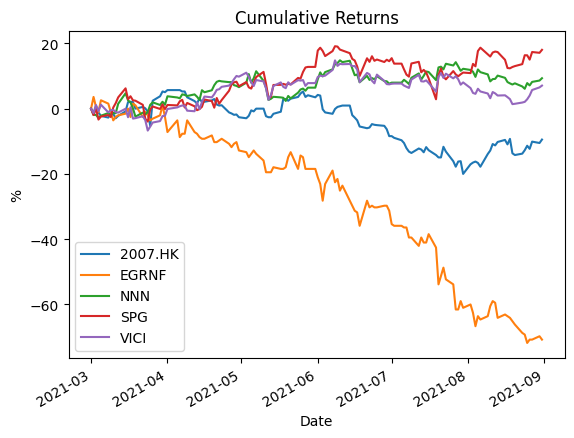

In [44]:
(((raw_data['Close'] / raw_data['Close'].iloc[0])-1)*100).plot()
plt.title('Cumulative Returns')
plt.ylabel('%')
plt.plot()

### Compute Log-Return

In [6]:
log_return = np.log(raw_data['Close'] / raw_data['Open'])

In [7]:
log_return.head()

,2007.HK,EGRNF,NNN,SPG,VICI
Date,,,,,
2021-03-01,-0.015666,-0.010204,-0.025169,-0.019816,-0.010681
2021-03-02,-0.015915,0.009950,-0.019706,-0.019156,-0.010826
2021-03-03,0.024301,-0.020203,0.000703,0.016719,0.023571
2021-03-04,-0.002128,-0.015425,-0.013385,-0.034982,-0.021751
2021-03-05,-0.021300,-0.014889,0.001409,-0.003502,0.006524


### Plot Histogram(s)

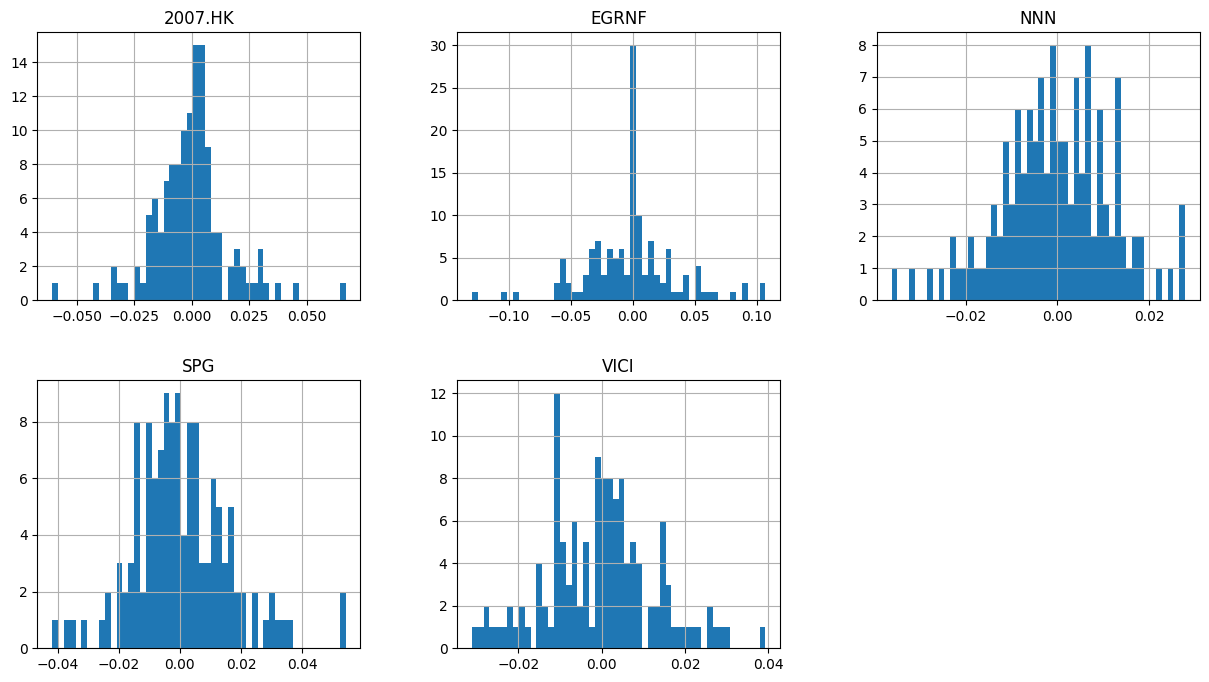

In [32]:
plot_hist(df=log_return)

### Plot Normal Probability Plot(s)

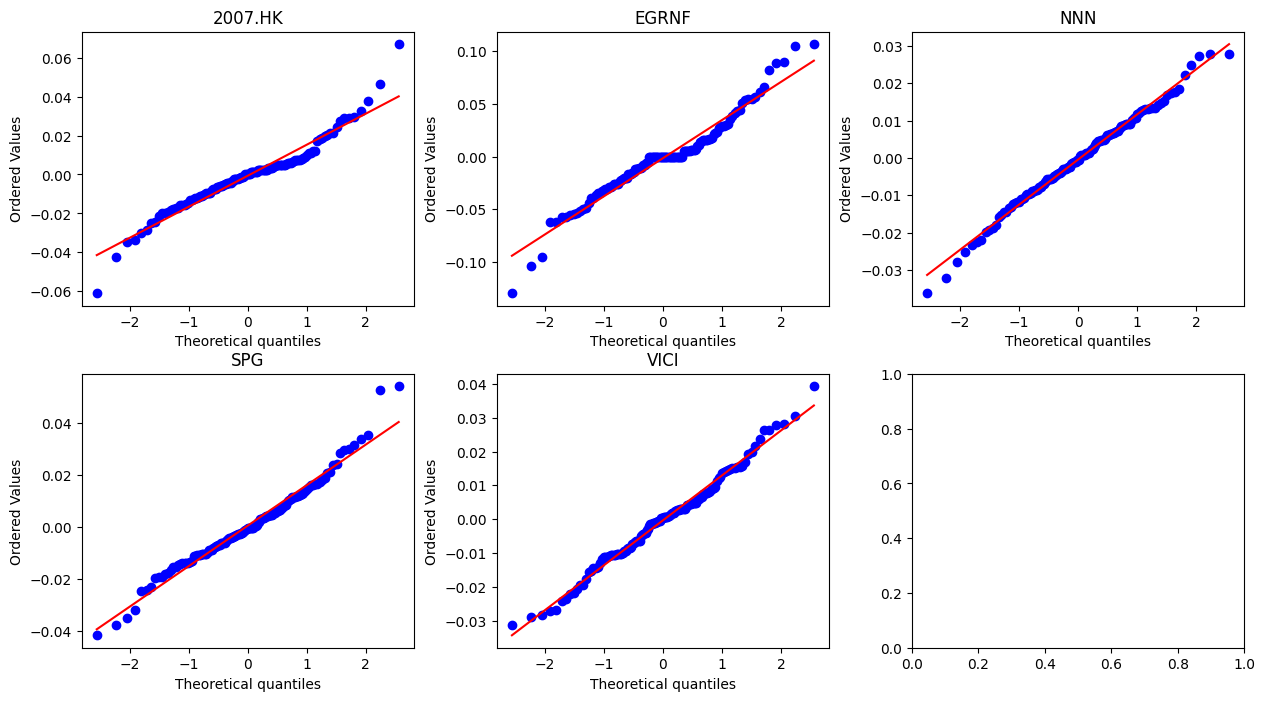

In [38]:
probplot(log_return)

### Compute Confidence Interval(s) of given symbol(s)

In [41]:
confidence_interval(log_return, conf_level=0.95)

,2007.HK,EGRNF,NNN,SPG,VICI
lower_bound,-0.003472,-0.007918,-0.002510,-0.002211,-0.002639
upper_bound,0.002159,0.004782,0.001629,0.003209,0.001924


### Run Regression for a symbol against time.

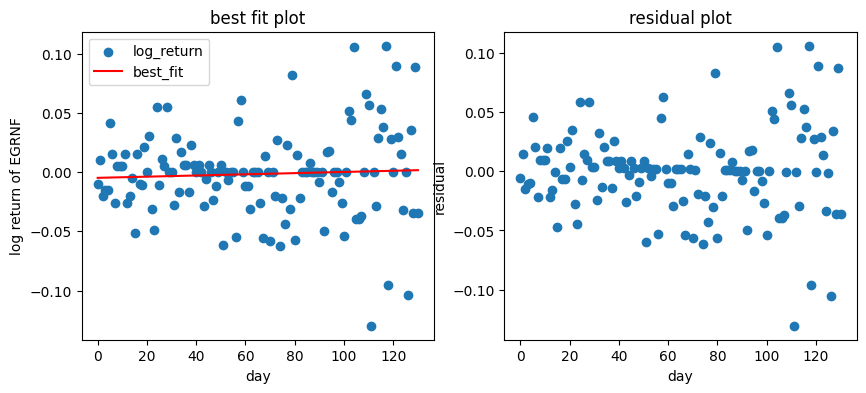

Intercept: -0.004802118262735114
Slope: 4.975521075400973e-05
R squared: 0.0026429222630337534


In [24]:
intercept, slope, rsquared  = return_time_reg(log_return, symbol='EGRNF')
print('Intercept:', intercept)
print('Slope:', slope)
print('R squared:', rsquared)

### Run Regression for a symbol against another symbol.

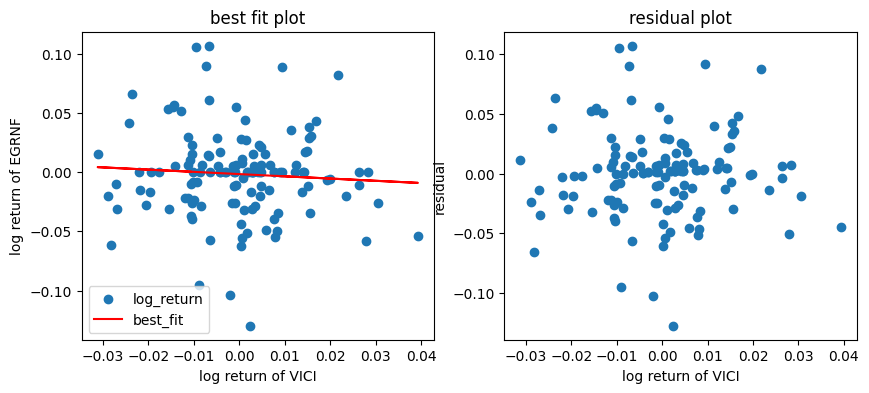

Intercept: -0.0016354872503254003
Slope: -0.18857151712142867
R squared: 0.004590380954134998


In [27]:
intercept, slope, rsquared  = return_reg(log_return, symbol_x='VICI', symbol_y='EGRNF')
print('Intercept:', intercept)
print('Slope:', slope)
print('R squared:', rsquared)

### Test the equality of population means of a pair of symbols.

In [28]:
symbol_1 = 'NNN'
symbol_2 = 'EGRNF'
res = mean_equality_test(log_return, symbol_1, symbol_2)
print(f"Are population means of {symbol_1} and {symbol_2} euqal?: {res}")

Are population means of NNN and EGRNF euqal?: True
